In [89]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader,TensorDataset
from IPython.display import display,clear_output
import tqdm

<Axes: >

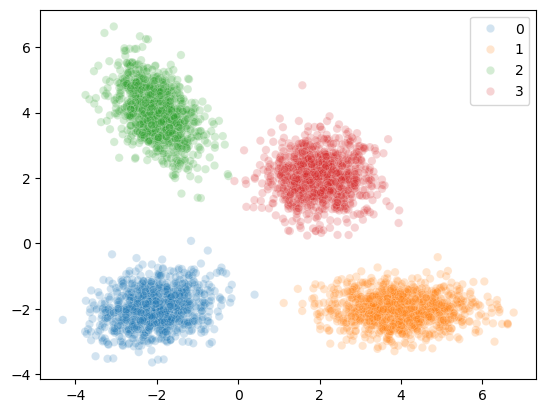

In [230]:
# Generate 4 Gaussian blobs in xy space with customizable parameters
np.random.seed(42)
torch.manual_seed(42)

# Define centers for the 4 blobs
centers = np.array([
    [-2, -2],
    [4, -2], 
    [-2, 4],
    [2, 2]
])

# Customizable parameters
n_samples_per_blob = [1000, 1000, 1000, 1000]  # Number of points in each blob
covariances = [
    [[0.5, 0.1], [0.1, 0.3]],    # Blob 1: elliptical, tilted
    [[0.8, 0], [0, 0.2]],        # Blob 2: horizontal ellipse
    [[0.3, -0.2], [-0.2, 0.6]],  # Blob 3: elliptical, negative tilt
    [[0.4, 0], [0, 0.4]]         # Blob 4: circular
]

# Generate data for each blob
data_points = []
labels = []
probabilities = []

for i, (center, n_samples, cov) in enumerate(zip(centers, n_samples_per_blob, covariances)):
    # Generate samples from multivariate normal distribution
    samples = np.random.multivariate_normal(
        mean=center, 
        cov=cov, 
        size=n_samples
    )
    data_points.append(samples)
    labels.extend([i] * n_samples)
    
    # Create probability distribution for each sample (one-hot encoding with some noise)
    prob_matrix = np.zeros((n_samples, 4))
    prob_matrix[:, i] = 0.8 + 0.15 * np.random.random(n_samples)  # Main cluster probability
    
    # Add small probabilities for other clusters
    for j in range(4):
        if j != i:
            prob_matrix[:, j] = 0.05 + 0.1 * np.random.random(n_samples)
    
    # Normalize to ensure probabilities sum to 1
    prob_matrix = prob_matrix / prob_matrix.sum(axis=1, keepdims=True)
    probabilities.append(prob_matrix)

# Combine all data points
X = np.vstack(data_points)
y = np.array(labels)
y_prob = np.vstack(probabilities)

# Convert to torch tensors
X_torch = torch.tensor(X, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.long)
y_prob = torch.tensor(y_prob, dtype=torch.float32)

dataset = TensorDataset(X_torch,y_torch)
dataloader = DataLoader(dataset,batch_size=200,shuffle=True)

sns.scatterplot(x=X[:,0],y=X[:,1],hue=y,palette="tab10",alpha=0.2)

In [231]:
class Clusterer(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64,4),
        )

    def forward(self,x):
        if len(x.shape) == 3:
            bs,k,d = x.shape
            x = x.reshape(bs*k,d)
        else:
            k=0
        if k:
            return self.net(x).reshape(bs,k,4)
        else:
            return self.net(x)



In [232]:
def interia_loss_calc(p, z, eps=1e-8):
    """
    Calculates a differentiable intra-cluster variance (inertia).

    Args:
        p (torch.Tensor): Soft cluster assignments (batch_size, num_clusters).
        z (torch.Tensor): Input data points (batch_size, num_features).
    
    Returns:
        torch.Tensor: The mean inertia value.
    """
    num_clusters = p.shape[1]
    total_inertia = 0.0
    
    # Calculate centroids and inertia for each cluster
    for i in range(num_clusters):
        # Get soft assignments for the current cluster
        p_i = p[:, i]  # Shape: (batch_size)
        
        # Calculate the sum of probabilities for normalization
        sum_p_i = torch.sum(p_i) + eps
        
        # Calculate weighted centroid
        # (batch_size, 1) * (batch_size, num_features) -> sum over batch_size
        centroid_i = torch.sum(p_i.unsqueeze(1) * z, dim=0) / sum_p_i
        
        # Calculate weighted squared distances to the centroid
        distances_sq = torch.sum((z - centroid_i) ** 2, dim=1)
        inertia_i = torch.sum(p_i * distances_sq)
        
        total_inertia += inertia_i
        
    return total_inertia / z.shape[0]

def ClusterLoss(p1,p2,z1,lamb=1.0,tau=1.0,eps=1e-12):

    p1 = F.softmax(p1,dim=1) #bs,c
    
    if len(p2.shape) == 2:
        p2 = p2.unsqueeze(1)
    p2 = F.softmax(p2,dim=2) #bs,k,c

    D,C = p1.shape
    
    dot_term = - 1/D * torch.sum(torch.log(torch.sum(p1.unsqueeze(1)*p2,dim=(2))+1e-10))
    #entropy term - get the average distribution across K
    
    P = p1.mean(dim=0)
    entropy = torch.sum(P * torch.log(P + 1e-10))
    
    
    interia = interia_loss_calc(p1, z1)
    return dot_term,entropy*lamb,interia*tau


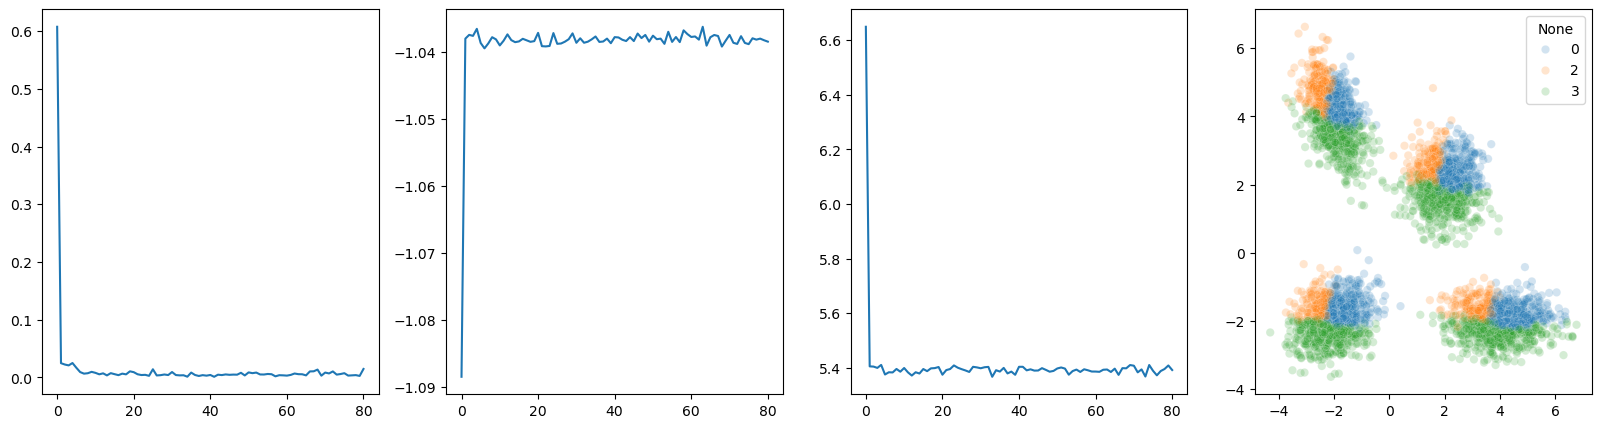

KeyboardInterrupt: 

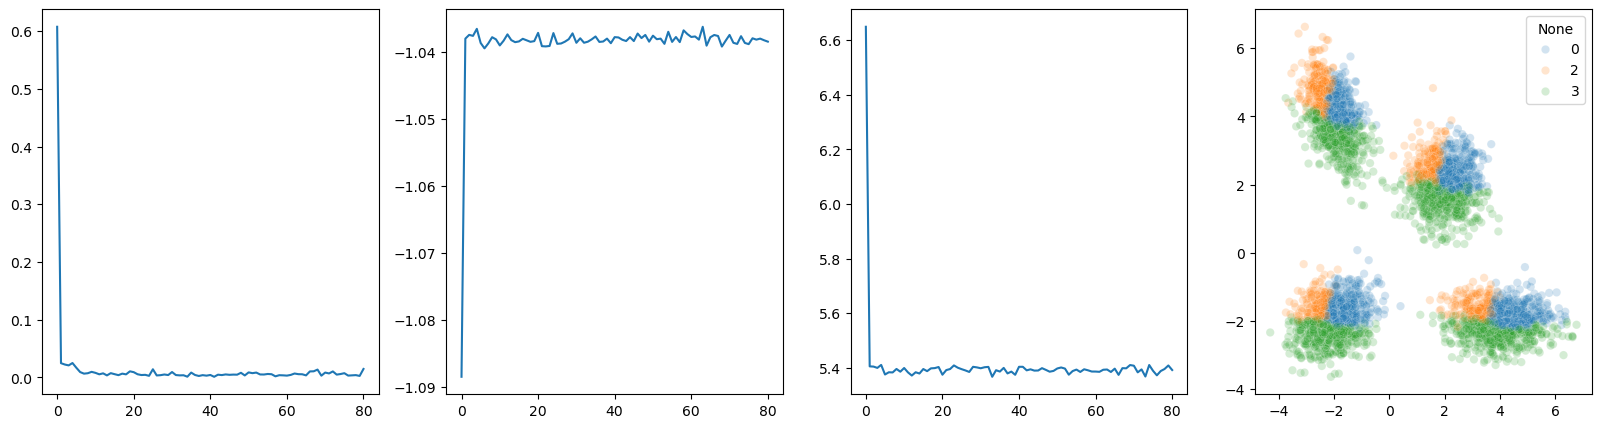

In [233]:
model = Clusterer()
device = 'cuda'
model = model.to(device)
optimizer = optim.Adam(model.parameters(),lr=0.1)
f,a = plt.subplots(1,4,figsize=(20,5))
dot_loss = []
ent_loss = []
interia_loss = []
dataloader = DataLoader(dataset,batch_size=500,shuffle=True)
for epoch in range(500):
    temp_dot = []
    temp_ent = []
    temp_interia = []
    for x,y in dataloader:
        optimizer.zero_grad()
        
        #find the knn of x 
        dist_mat = torch.cdist(x,x)
        nn_idx = torch.argsort(dist_mat,dim=1)[:,:3]
        x1,x2 = x+torch.randn_like(x)*0.05,x[nn_idx]+torch.randn_like(x[nn_idx])*0.05
        p1,p2 = model(x1.to(device)),model(x2.to(device))
        dot,ent,interia = ClusterLoss(p1,p2,x1.to(device),lamb=1.0,tau=1.0)
        
        loss = dot + ent + interia
        loss.backward()
        optimizer.step()
        temp_dot.append(dot.item())
        temp_ent.append(ent.item())
        temp_interia.append(interia.item())
    
    dot_loss.append(np.mean(temp_dot))
    ent_loss.append(np.mean(temp_ent))
    interia_loss.append(np.mean(temp_interia))

    if epoch % 10 == 0:
        clear_output()
        for ax in a: ax.clear()
        a[0].plot(dot_loss)
        a[1].plot(ent_loss)
        a[2].plot(interia_loss)
        #get the predictions
        
        test_dataloader = DataLoader(dataset,batch_size=100,shuffle=False)
        y_pred = []
        with torch.no_grad():
            for x,y in test_dataloader:
                x = x.to(device)
                p = model(x).argmax(dim=1).cpu()
                y_pred.append(p)

        y_pred = torch.cat(y_pred)
        sns.scatterplot(x=X[:,0],y=X[:,1],hue=y_pred,palette="tab10",alpha=0.2,ax=a[3])
        display(f)

In [205]:
#get the predictions
test_dataloader = DataLoader(dataset,batch_size=100,shuffle=False)
y_pred = []
with torch.no_grad():
    for x,y in test_dataloader:
        x = x.to(device)
        p = model(x).cpu()
        y_pred.append(p)

y_pred = torch.cat(y_pred)


In [222]:
ClusterLoss(y_prob,y_prob,X_torch)

tensor([0.3966, 0.1992, 0.2058, 0.1984])
tensor([0.3966, 0.1992, 0.2058, 0.1984])
tensor(8.6483)


(tensor(1.2833), tensor(-1.3863), tensor(8.6483))

In [223]:
eprob = torch.exp(y_prob/0.2)
ClusterLoss(eprob,eprob,X_torch)

tensor([1.0000e+00, 1.8521e-19, 2.3777e-19, 1.8010e-19])
tensor([1.0000e+00, 1.8521e-19, 2.3777e-19, 1.8010e-19])
tensor(0.8835)


(tensor(-0.), tensor(-1.3863), tensor(0.8835))

In [224]:
eprob

tensor([[44.5573,  1.4245,  1.6743,  1.3965],
        [38.4468,  1.6147,  1.7953,  1.3316],
        [34.6565,  1.7201,  1.8148,  1.3719],
        ...,
        [ 1.7969,  1.8004,  1.4378, 31.9063],
        [ 1.4442,  1.4476,  1.7038, 41.6654],
        [ 1.7451,  1.7090,  1.6477, 30.2023]])

In [225]:
interia_loss_calc(F.softmax(y_pred,dim=1),X_torch),interia_loss_calc(F.softmax(eprob,dim=1),X_torch)

(tensor(8.4789), tensor(0.8835))